<a href="https://colab.research.google.com/github/patrick-cw/second_ball/blob/main/Second_Ball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cmasher
!pip install statsbombpy
!pip install mplsoccer
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
from statsbombpy import sb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 367 kB 13.4 MB/s 
     |████████████████████████████████| 40 kB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 4.1 MB/s 
     |████████████████████████████████| 152 kB 22.7 MB/s 
     |████████████████████████████████| 127 kB 69.1 MB/s 
     |████████████████████████████████| 60 kB 7.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      Successfully uninstalled attrs-22.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 2.2 M

In [ ]:
cred_dict = {'user':'juliansfeir1@gmail.com', 'passwd':'JoPVwpbh'}
sb.competitions(creds=cred_dict)

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,49,106,United States of America,NWSL,female,False,False,2022,2022-08-21T13:03:39.924255,None,None,2022-08-21T13:03:39.924255
1,49,91,United States of America,NWSL,female,False,False,2021,2022-08-07T23:38:59.559576,2021-06-13T16:17:31.694,None,2022-08-07T23:38:59.559576
2,49,43,United States of America,NWSL,female,False,False,2020,None,None,None,None
3,49,30,United States of America,NWSL,female,False,False,2019,2022-07-06T12:44:26.130325,2021-06-13T16:17:31.694,None,2022-07-06T12:44:26.130325
4,49,3,United States of America,NWSL,female,False,False,2018,2021-11-06T05:53:29.435016,2021-06-13T16:17:31.694,None,2021-11-06T05:53:29.435016
5,120,106,United States of America,NWSL Challenge Cup,female,False,False,2022,2022-07-24T23:39:34.669510,None,None,2022-07-24T23:39:34.669510
6,120,91,United States of America,NWSL Challenge Cup,female,False,False,2021,2022-06-30T17:02:21.779934,2021-06-13T16:17:31.694,None,2022-06-30T17:02:21.779934
7,120,43,United States of America,NWSL Challenge Cup,female,False,False,2020,2021-05-23T16:09:11.776,2021-06-13T16:17:31.694,None,2021-05-23T16:09:11.776
8,159,43,United States of America,NWSL Fall Series,female,False,False,2020,2021-04-28T19:48:01.137312,2021-06-13T16:17:31.694,None,2021-04-28T19:48:01.137312
9,55,43,Europe,UEFA Euro,male,False,True,2020,2022-02-01T17:20:34.319496,2022-08-04T12:00,2022-08-04T12:00,2022-02-01T17:20:34.319496


In [ ]:
match_ids = sb.matches(competition_id=49, season_id=91, creds=cred_dict).match_id.tolist()

In [ ]:
def convert_coordinates(x):
  if type(x) == list:  
    if x[0] < 60:
      x_new = 120 - x[0]
    else:
      x_new = x[0]
      
    y_new = x[1]

    return [x_new, y_new]
  
  else:
    return np.nan

In [ ]:
from tqdm import tqdm
import pandas as pd 

event_all = pd.DataFrame()

for i in tqdm(match_ids):
    event = sb.events(i, creds=cred_dict)
    event = event[event.type !='Starting XI']
    event = event[event.type !='Half Start']
    event = event[event.type !='Tactical Shift']
    event = event[event.type !='Half End']
    event = event[event.type !='Substitution']
    event = event[event.type !='Bad Behaviour']
    event = event[event.type !='Ball Receipt*']
    event = event[event.type !='Duel']
    event = event[event.type !='Pressure']
    events_clean = event.sort_values(['period', 'timestamp'])[['id', 'period', 'timestamp', 'player', 'team', 'type', 'location', 'pass_type','shot_outcome','shot_type','goalkeeper_outcome']].reset_index(drop=True)
    index = events_clean[events_clean.pass_type == 'Corner'].index.tolist()
    index2 = [x+2 for x in index]
    corner = pd.DataFrame()
    for i in index:
        x = events_clean.loc[:i].tail(1)
        j = i+2
        a = events_clean.loc[:j].tail(3)
        # Get the event at t+1 from the previous event
        events_1 = a.shift(-1)

        # Get the event at t+2 from the previous event
        events_2 = a.shift(-2)

        # Join the events to the parent row
        events_join = x.join(events_1, rsuffix='_1').join(events_2, rsuffix='_2')
        corner = corner.append(events_join, ignore_index=True)

    # Mirrored the clearance to 120 - x (In case x < 60)
    corner['location'] = corner.location.apply(lambda x: convert_coordinates(x))
    corner['location_1'] = corner.location_1.apply(lambda x: convert_coordinates(x))  
    corner['location_2'] = corner.location_2.apply(lambda x: convert_coordinates(x))
    event_all = event_all.append(corner,ignore_index=True)


  0%|          | 0/122 [00:00<?, ?it/s]

In [ ]:
event_all.to_csv('corner_data.csv')

In [ ]:
event_all.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1224 non-null   object 
 1   period                1224 non-null   int64  
 2   timestamp             1224 non-null   object 
 3   player                1224 non-null   object 
 4   team                  1224 non-null   object 
 5   type                  1224 non-null   object 
 6   location              1224 non-null   object 
 7   pass_type             1224 non-null   object 
 8   shot_outcome          0 non-null      object 
 9   shot_type             0 non-null      object 
 10  goalkeeper_outcome    0 non-null      object 
 11  id_1                  1222 non-null   object 
 12  period_1              1222 non-null   float64
 13  timestamp_1           1222 non-null   object 
 14  player_1              1222 non-null   object 
 15  team_1               

In [ ]:
events = event_all[['player','player_1','player_2','team', 'team_1', 'team_2','pass_type', 'type_1', 'type_2', 'location', 'location_1', 'location_2', 'shot_outcome_1','shot_outcome_2','goalkeeper_outcome_1','goalkeeper_outcome_2']]
#events.to_csv('corner_data_filtered.csv')

In [ ]:
events

,player,player_1,player_2,team,team_1,team_2,pass_type,type_1,type_2,location,location_1,location_2,shot_outcome_1,shot_outcome_2,goalkeeper_outcome_1,goalkeeper_outcome_2
0,Mallory Pugh,Tierna Lillis Davidson,Tierna Lillis Davidson,Chicago Red Stars,Chicago Red Stars,Chicago Red Stars,Corner,Carry,Pass,"[120.0, 80.0]","[100.3, 30.3]","[99.9, 25.1]",NaN,NaN,NaN,NaN
1,Mallory Pugh,Caprice Dydasco,Tierna Lillis Davidson,Chicago Red Stars,NJ/NY Gotham FC,Chicago Red Stars,Corner,Clearance,Pass,"[120.0, 0.1]","[116.4, 40.0]","[103.6, 20.7]",NaN,NaN,NaN,NaN
2,Mallory Pugh,Sarah Killion,Sarah Killion,Chicago Red Stars,Chicago Red Stars,Chicago Red Stars,Corner,Carry,Pass,"[120.0, 0.1]","[115.3, 25.9]","[111.6, 17.1]",NaN,NaN,NaN,NaN
3,Mallory Pugh,Kailen Mary Iacovoni Sheridan,Caprice Dydasco,Chicago Red Stars,NJ/NY Gotham FC,NJ/NY Gotham FC,Corner,Pass,Carry,"[120.0, 80.0]","[114.0, 44.0]","[66.0, 72.9]",NaN,NaN,NaN,NaN
4,Mallory Pugh,Kailen Mary Iacovoni Sheridan,Kailen Mary Iacovoni Sheridan,Chicago Red Stars,NJ/NY Gotham FC,NJ/NY Gotham FC,Corner,Carry,Goal Keeper,"[120.0, 80.0]","[116.0, 45.6]","[116.0, 45.6]",NaN,NaN,NaN,Success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,Débora Cristiane de Oliveira,Carson Pickett,Carson Pickett,North Carolina Courage,North Carolina Courage,North Carolina Courage,Corner,Carry,Dispossessed,"[120.0, 0.1]","[114.9, 2.3]","[114.9, 6.3]",NaN,NaN,NaN,NaN
1220,Tierna Lillis Davidson,Merritt Mathias,Vanessa DiBernardo,Chicago Red Stars,North Carolina Courage,Chicago Red Stars,Corner,Clearance,Pass,"[120.0, 0.1]","[112.7, 45.4]","[96.0, 32.7]",NaN,NaN,NaN,NaN
1221,Carson Pickett,Morgan Paige Gautrat,Hailie Mace,North Carolina Courage,Chicago Red Stars,North Carolina Courage,Corner,Clearance,Carry,"[120.0, 80.0]","[113.0, 44.2]","[93.0, 27.0]",NaN,NaN,NaN,NaN
1222,Carson Pickett,Abby Erceg,Vanessa DiBernardo,North Carolina Courage,North Carolina Courage,Chicago Red Stars,Corner,Pass,Clearance,"[120.0, 0.1]","[112.7, 45.5]","[111.6, 41.6]",NaN,NaN,NaN,NaN


In [ ]:
events['corner_x'] = events.location.apply(lambda x: x[0])
events['corner_y'] = events.location.apply(lambda x: x[1])
events['first_ball_x'] = events.location_1.apply(lambda x: x[0])
events['first_ball_y'] = events.location_1.apply(lambda x: x[1])
events['second_ball_x'] = events.location_2.apply(lambda x: x[0])
events['second_ball_y'] = events.location_2.apply(lambda x: x[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TypeError: ignored

In [ ]:
left_corner = events.loc[events['corner_y']>=79]
right_corner = events.loc[events['corner_y']<=1]

In [ ]:
events_pass = events.loc[(events['type_1']== 'Pass')]
events_pass_shot = events.loc[(events['type_1']== 'Pass') & (events['type_2']== 'Shot')]
events_keeper = events.loc[(events['type_1']== 'Goal Keeper') & (events['type_2']== 'Shot')]

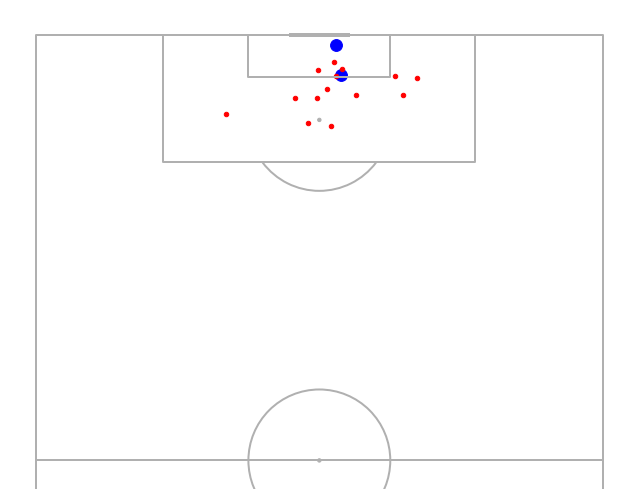

In [ ]:
from matplotlib import pyplot as plt
pitch = VerticalPitch(pitch_type='statsbomb', half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(12, 7))
for i, x in events_pass_shot.iterrows():
    goal = x['shot_outcome_2']
    if goal == 'Goal':
      x_coord = x['second_ball_x']
      y_coord = x['second_ball_y']
      pitch.scatter(x_coord, y_coord, s=140, c = 'blue', ax=ax)
    else:
      x_coord = x['second_ball_x']
      y_coord = x['second_ball_y']
      pitch.scatter(x_coord, y_coord,s=20, c = 'red', ax=ax)
   
ax.title('Shot')
plt.show()

In [ ]:
events_pass

,player,player_1,player_2,team,team_1,team_2,pass_type,type_1,type_2,location,location_1,location_2,shot_outcome_1,shot_outcome_2,goalkeeper_outcome_1,goalkeeper_outcome_2,second_ball_x,second_ball_y
3,Mallory Pugh,Kailen Mary Iacovoni Sheridan,Caprice Dydasco,Chicago Red Stars,NJ/NY Gotham FC,NJ/NY Gotham FC,Corner,Pass,Carry,"[120.0, 80.0]","[114.0, 44.0]","[66.0, 72.9]",NaN,NaN,NaN,NaN,66.0,72.9
11,Mallory Pugh,Morgan Paige Gautrat,Kelley Maureen O''Hara,Chicago Red Stars,Chicago Red Stars,Washington Spirit,Corner,Pass,Clearance,"[120.0, 0.1]","[109.5, 47.1]","[111.0, 48.0]",NaN,NaN,NaN,NaN,111.0,48.0
20,Andi Sullivan,Emily Ann Sonnett,Samantha Staab,Washington Spirit,Washington Spirit,Washington Spirit,Corner,Pass,Carry,"[120.0, 80.0]","[111.2, 39.6]","[110.3, 34.8]",NaN,NaN,NaN,NaN,110.3,34.8
23,Megan Anna Rapinoe,Eugénie Le Sommer,Quinn Quinn,OL Reign,OL Reign,OL Reign,Corner,Pass,Pass,"[120.0, 0.1]","[118.7, 46.8]","[112.5, 37.4]",NaN,NaN,NaN,NaN,112.5,37.4
25,Megan Anna Rapinoe,Eugénie Le Sommer,Andi Sullivan,OL Reign,OL Reign,Washington Spirit,Corner,Pass,Clearance,"[120.0, 0.1]","[117.7, 50.8]","[116.5, 38.7]",NaN,NaN,NaN,NaN,116.5,38.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,Natalia Kuikka,Jane Campbell,Lindsey Michelle Horan,Portland Thorns,Houston Dash,Portland Thorns,Corner,Pass,Pass,"[120.0, 80.0]","[114.0, 44.0]","[68.1, 5.1]",NaN,NaN,NaN,NaN,68.1,5.1
1197,Caprice Dydasco,Gina Lewandowski,Freja Olofsson,NJ/NY Gotham FC,NJ/NY Gotham FC,Racing Louisville FC,Corner,Pass,Clearance,"[120.0, 0.1]","[110.6, 45.7]","[114.8, 43.6]",NaN,NaN,NaN,NaN,114.8,43.6
1203,Katie McClure,Nealy Martin,Amy Turner,Racing Louisville FC,Racing Louisville FC,Orlando Pride,Corner,Pass,Clearance,"[120.0, 0.1]","[115.3, 32.9]","[116.6, 38.0]",NaN,NaN,NaN,NaN,116.6,38.0
1214,Tierna Lillis Davidson,Morgan Paige Gautrat,Rachel Hill,Chicago Red Stars,Chicago Red Stars,Chicago Red Stars,Corner,Pass,Foul Committed,"[120.0, 0.1]","[112.1, 42.7]","[114.7, 30.8]",NaN,NaN,NaN,NaN,114.7,30.8


In [ ]:
events_pass = events_pass.loc[events_pass['second_ball_x']>90]

In [ ]:
events_pass

,player,player_1,player_2,team,team_1,team_2,pass_type,type_1,type_2,location,location_1,location_2,shot_outcome_1,shot_outcome_2,goalkeeper_outcome_1,goalkeeper_outcome_2,second_ball_x,second_ball_y
11,Mallory Pugh,Morgan Paige Gautrat,Kelley Maureen O''Hara,Chicago Red Stars,Chicago Red Stars,Washington Spirit,Corner,Pass,Clearance,"[120.0, 0.1]","[109.5, 47.1]","[111.0, 48.0]",NaN,NaN,NaN,NaN,111.0,48.0
20,Andi Sullivan,Emily Ann Sonnett,Samantha Staab,Washington Spirit,Washington Spirit,Washington Spirit,Corner,Pass,Carry,"[120.0, 80.0]","[111.2, 39.6]","[110.3, 34.8]",NaN,NaN,NaN,NaN,110.3,34.8
23,Megan Anna Rapinoe,Eugénie Le Sommer,Quinn Quinn,OL Reign,OL Reign,OL Reign,Corner,Pass,Pass,"[120.0, 0.1]","[118.7, 46.8]","[112.5, 37.4]",NaN,NaN,NaN,NaN,112.5,37.4
25,Megan Anna Rapinoe,Eugénie Le Sommer,Andi Sullivan,OL Reign,OL Reign,Washington Spirit,Corner,Pass,Clearance,"[120.0, 0.1]","[117.7, 50.8]","[116.5, 38.7]",NaN,NaN,NaN,NaN,116.5,38.7
31,Angela Salem,Meghan Klingenberg,Sarah Killion,Portland Thorns,Portland Thorns,Chicago Red Stars,Corner,Pass,Clearance,"[120.0, 80.0]","[91.9, 27.5]","[111.8, 35.4]",NaN,NaN,NaN,NaN,111.8,35.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,Angela Salem,Raquel Rodriguez,Kristie Mewis,Portland Thorns,Portland Thorns,Houston Dash,Corner,Pass,Clearance,"[120.0, 80.0]","[115.6, 46.8]","[114.7, 43.1]",NaN,NaN,NaN,NaN,114.7,43.1
1197,Caprice Dydasco,Gina Lewandowski,Freja Olofsson,NJ/NY Gotham FC,NJ/NY Gotham FC,Racing Louisville FC,Corner,Pass,Clearance,"[120.0, 0.1]","[110.6, 45.7]","[114.8, 43.6]",NaN,NaN,NaN,NaN,114.8,43.6
1203,Katie McClure,Nealy Martin,Amy Turner,Racing Louisville FC,Racing Louisville FC,Orlando Pride,Corner,Pass,Clearance,"[120.0, 0.1]","[115.3, 32.9]","[116.6, 38.0]",NaN,NaN,NaN,NaN,116.6,38.0
1214,Tierna Lillis Davidson,Morgan Paige Gautrat,Rachel Hill,Chicago Red Stars,Chicago Red Stars,Chicago Red Stars,Corner,Pass,Foul Committed,"[120.0, 0.1]","[112.1, 42.7]","[114.7, 30.8]",NaN,NaN,NaN,NaN,114.7,30.8


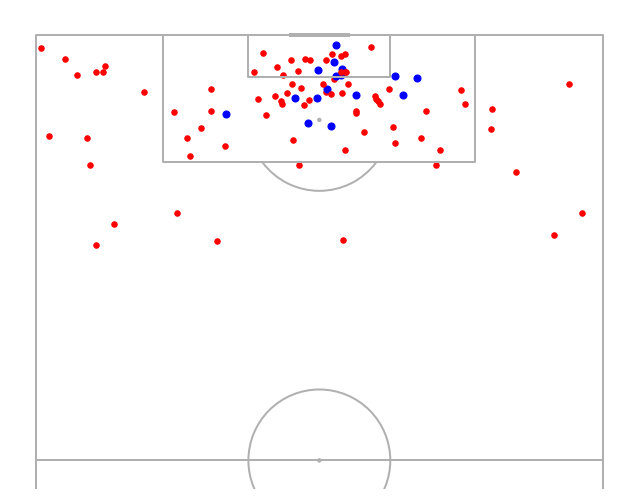

In [ ]:
from matplotlib import pyplot as plt
pitch = VerticalPitch(pitch_type='statsbomb', half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(12, 7))
for i, x in events_pass.iterrows():
    type_data = x['type_2']
    if type_data == 'Shot':
      x_coord = x['second_ball_x']
      y_coord = x['second_ball_y']
      pitch.scatter(x_coord, y_coord, s=50, c = 'blue', ax=ax)
    else:
      x_coord = x['second_ball_x']
      y_coord = x['second_ball_y']
      pitch.scatter(x_coord, y_coord,s=30, c = 'red', ax=ax)
   
#draw_pitch(ax)
plt.show()